In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta

# 定义AR(1)模型的参数
phi = 0.8  # 自回归系数
sigma_epsilon = 1  # 白噪声的标准差，并且假设服从标准正态分布，即，ε服从(0,1)标准正态分布
N = 5000  # 时间步数
initial_time = pd.Timestamp("2000-03-06 09:30:00")  # 初始时间

# 将参数保存到JSON文件中
params = {"phi": phi, "sigma_epsilon": sigma_epsilon, "N": N}
with open('./test/arma_params.json', 'w') as file:
    json.dump(params, file)

# 从JSON文件中加载参数
with open('./test/arma_params.json', 'r') as file:
    loaded_params = json.load(file)
phi = loaded_params["phi"]
sigma_epsilon = loaded_params["sigma_epsilon"]
N = loaded_params["N"]

# 生成时间戳
timestamps = pd.date_range(start=initial_time, periods=N, freq='T').to_series()

# 过滤非工作时间（上午9:30至下午3:00）
timestamps = timestamps.between_time('09:30', '15:00')
timestamps

2000-03-06 09:30:00   2000-03-06 09:30:00
2000-03-06 09:31:00   2000-03-06 09:31:00
2000-03-06 09:32:00   2000-03-06 09:32:00
2000-03-06 09:33:00   2000-03-06 09:33:00
2000-03-06 09:34:00   2000-03-06 09:34:00
                              ...        
2000-03-09 14:56:00   2000-03-09 14:56:00
2000-03-09 14:57:00   2000-03-09 14:57:00
2000-03-09 14:58:00   2000-03-09 14:58:00
2000-03-09 14:59:00   2000-03-09 14:59:00
2000-03-09 15:00:00   2000-03-09 15:00:00
Length: 1324, dtype: datetime64[ns]

In [3]:
#模拟AR(1)过程的函数
def adjusted_simulate_ar1(phi, sigma, timestamps):
    if isinstance(timestamps, pd.Series):#如果直接输入时间序列
        N = len(timestamps) #找出时间序列的长度，递给epsilon
    elif isinstance(timestamps, int): #如果直接给整数，直接给epsilon，便于解释随着N上升参数估计精确度如何变化的问题
        N = timestamps
    else :
        print("输入类型错误")

    epsilon = np.random.normal(0, sigma, size=N) #ε服从(0,1)标准正态分布
    X = np.zeros(N)
    X[0] = epsilon[0] #设置X_t初始值
    for t in range(1, N):
        X[t] = phi * X[t-1] + epsilon[t]
    return pd.DataFrame(X, index=timestamps, columns=['Time Series'])



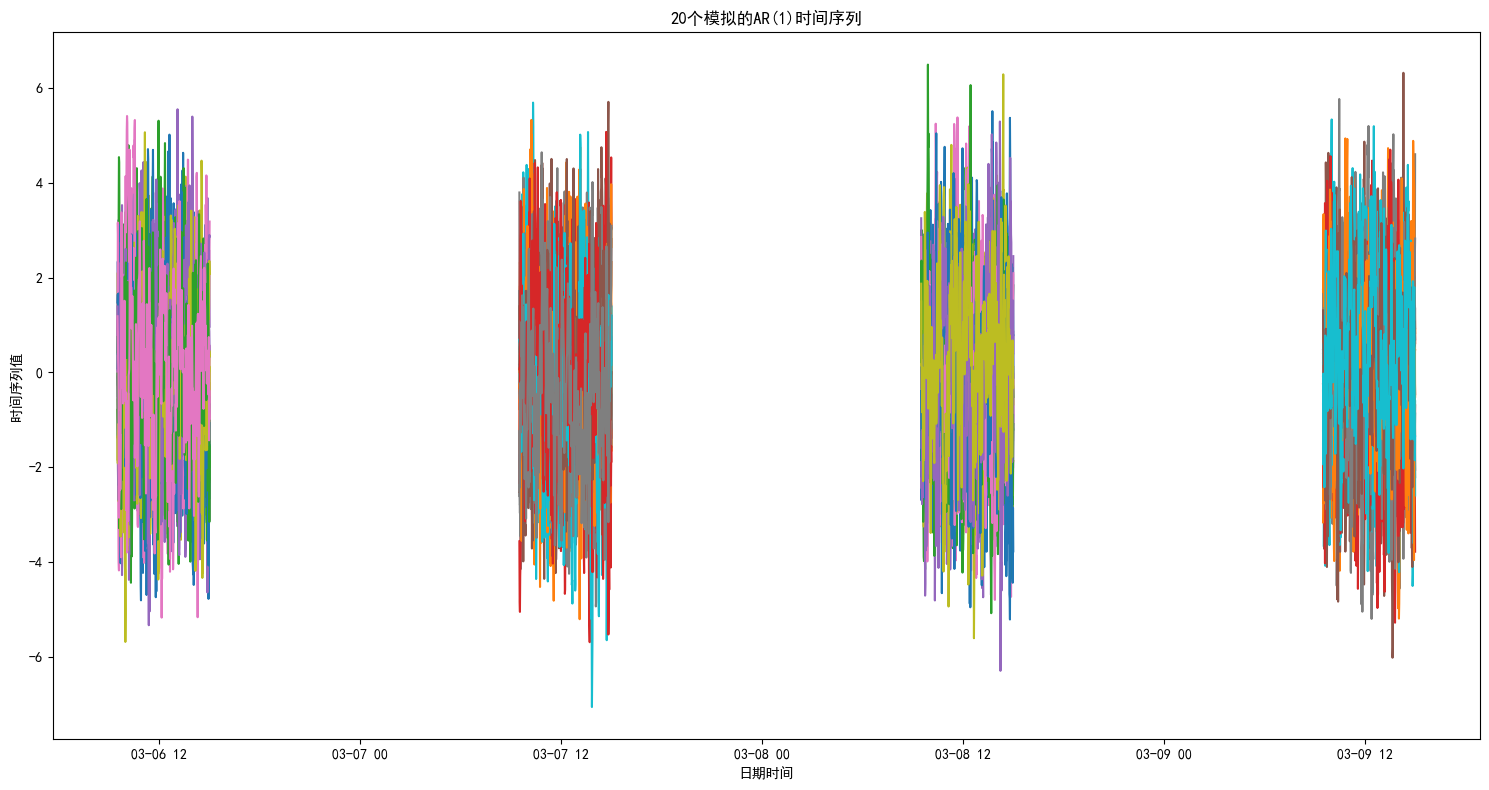

In [4]:
# 模拟20个时间序列并绘图
plt.figure(figsize=(15, 8))
# for i in range(20):
#     ts = adjusted_simulate_ar1(phi, sigma_epsilon, timestamps)
#     plt.plot(ts.index, ts['Time Series'], label=f'序列 {i+1}')

for i in range(20):
    ts = adjusted_simulate_ar1(phi, sigma_epsilon, timestamps)
    # 为每个工作日的数据绘图，避免连接非工作时间的数据点
    for day in ts.index.normalize().unique():
        daily_data = ts[ts.index.normalize() == day]
        plt.plot(daily_data.index, daily_data['Time Series'], label=f'序列 {i+1}' if i == 0 else "")

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文支持的字体，如 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 设置图例和标签
plt.xlabel('日期时间')
plt.ylabel('时间序列值')
plt.title('20个模拟的AR(1)时间序列')
plt.tight_layout()
plt.show()

In [10]:
# 定义一个函数来估计不同时间步长下的 ARIMA 参数
from statsmodels.tsa.arima.model import ARIMA
def estimate_arima_params(phi, sigma, N):
    timestamps = pd.date_range(start=initial_time, periods=N, freq='T').to_series()
    timestamps = timestamps.between_time('09:30', '15:00')
    ts = adjusted_simulate_ar1(phi, sigma, timestamps)
    model = ARIMA(ts, order=(1, 0, 0))
    results = model.fit()
    estimated_phi = results.params['ar.L1']
    estimated_sigma = np.sqrt(results.params['sigma2'])
    return estimated_phi, estimated_sigma

# 使用不同的 N 值进行估计
N_values = [100, 1000, 5000, 10000]  # 不同的时间步长
estimations = []

for N in N_values:
    est_phi, est_sigma = estimate_arima_params(phi, sigma_epsilon, N)
    estimations.append({
        "N": N,
        "估计的 φ": est_phi,
        "估计的 σ": est_sigma
    })

estimations #可以看到，随着样本量的增大，参数估计的准确度是越来越高的




C:\Program Files\anacoda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Program Files\anacoda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Program Files\anacoda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Program Files\anacoda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Program Files\anacoda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self.

[{'N': 100, '估计的 φ': 0.8231425344558746, '估计的 σ': 1.0201247258482837},
 {'N': 1000, '估计的 φ': 0.7845688595621813, '估计的 σ': 1.0137639289741118},
 {'N': 5000, '估计的 φ': 0.760166618629543, '估计的 σ': 1.0320210862508128},
 {'N': 10000, '估计的 φ': 0.8006561772229156, '估计的 σ': 0.9830580117390973}]